In [1]:
# Display output of plots directly in Notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import intake_esm
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal

# http://gallery.pangeo.io/repos/NCAR/cesm-lens-aws/notebooks/kay-et-al-2015.v3.html

In [2]:
# Open collection description file
catalog_url = 'https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json'
col = intake_esm.esm_datastore(catalog_url)
col

,unique
variable,77
long_name,74
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


In [13]:
df = col.df.copy()

In [16]:
df = df.dropna(subset=['variable'])

In [20]:
df[df.long_name.str.contains("temp")].variable.value_counts()

TS            11
TREFHT        11
TREFHTMX       8
TREFHTMN       8
T              7
TEMP           4
SST            4
TREFMNAV_U     1
TREFMXAV_U     1
Name: variable, dtype: int64

In [3]:
col_subset = col.search(frequency=["monthly"], component="atm", variable="TS",
                        experiment=["20C", "RCP85", "HIST"])

col_subset

,unique
variable,1
long_name,1
component,1
experiment,3
frequency,1
vertical_levels,1
spatial_domain,1
units,1
start_time,3
end_time,3


In [4]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['atm.HIST.monthly', 'atm.20C.monthly', 'atm.RCP85.monthly'])


In [6]:
# Define Xarray datasets corresponding to the three experiments
ds_HIST = dsets['atm.HIST.monthly']
ds_20C = dsets['atm.20C.monthly']
ds_RCP85 = dsets['atm.RCP85.monthly']

In [8]:
# Use Dask.Distributed utility function to display size of each dataset
from distributed.utils import format_bytes
print(f"Historical: {format_bytes(ds_HIST.nbytes)}\n"
      f"20th Century: {format_bytes(ds_20C.nbytes)}\n"
      f"RCP8.5: {format_bytes(ds_RCP85.nbytes)}")

Historical: 177.21 MiB
20th Century: 8.50 GiB
RCP8.5: 9.39 GiB


In [76]:
t_20c = ds_20C["TS"].sel(time=slice("1940", "2006"))

In [80]:
def is_summer(month):
    return (month >= 7) & (month <= 10)

t20_summer = t_20c.sel(time=is_summer(t_20c['time.month']))

In [81]:
t20_summer

,Array,Chunk
Bytes,2.18 GiB,32.06 MiB
Shape,"(40, 264, 192, 288)","(1, 152, 192, 288)"
Count,241 Tasks,80 Chunks
Type,float32,numpy.ndarray


In [215]:
def filter_lats(lat, bbox):
    lat_min, lat_max = bbox
    return (lat <= lat_max) & (lat >= lat_min)

def filter_lons(lon, bbox):
    lon_min, lon_max = bbox
    if lon_min > lon_max: # wrap-around case:
        return (lon >= lon_min) | (lon <= lon_max)
    else:
        return (lon <= lon_max) & (lon >= lon_min)


indices = {
    'Nino12': [[270, 280], [-10, 0]],
    'Nino3': [[210, 270], [-5,5]],
    'Nino34': [[190, 240], [-5,5]],
    #'Nino4': [[160, 210], [-5,5]],
    
    'TNA': [[305, 345], [-5, 25]],
    'TSA': [[330, 10], [-20, 0]],
    #'AMO': [[0, 360], [0, 70]],
    
    'SWIO': [[31, 45], [-32, -25]],
    'WTIO': [[50, 70], [-10, 10]],
    'SETIO': [[90, 110], [-10, 10]],
    
    'NZI': [[170, 200], [-40, -25]]            
}

In [129]:
for clix in indices:
    print(clix)
    bbox = indices[clix]
    t20_summer.where(filter_lats(t20_summer['lat'], bbox[1])&filter_lons(t20_summer['lon'], bbox[0]), 
                     drop=True).to_dataframe().reset_index().to_csv('../data/climate_indices/{}.csv'.format(clix), index=False)


Nino4
TNA
TSA
AMO
SWIO
WTIO
SETIO
NZI


In [216]:
# AMO too big we're ignoring 

months = {
    7: 'july',
    8: 'aug',
    9: 'sept',
    10: 'oct'
}

for clix in indices: 
    print(clix)
    df = pd.read_csv('../data/climate_indices/{}.csv'.format(clix))
    
    df['time'] = pd.to_datetime(df.time)
    df['month'] = df.time.apply(lambda x: x.month)
    df['year'] = df.time.apply(lambda x: x.year)
    
    # compute monthly anomaly relative to 1950-1979, per thing i read https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni
    df0 = df.pivot_table(index=['member_id', 'month', 'year'], 
                     columns=['lat', 'lon'], values='TS').mean(axis=1).reset_index()
    df0.rename(columns={0: 'region_avg'}, inplace=True)

    baseline = df0[df0.year.between(1950, 1979)].groupby(['member_id', 'month']).region_avg.agg(['mean', 'std']).reset_index()
    baseline.rename(columns={'mean': 'region_avg_baseline', 'std':'region_std_baseline'}, inplace=True)
    df0 = pd.merge(df0, baseline)
    df0['anomaly'] = (df0.region_avg - df0.region_avg_baseline)/df0.region_std_baseline
    
    # detrend each month/ensemble member
    df = pd.DataFrame()

    for ens in df0.member_id.unique():
        tmp = df0[df0.member_id == ens].pivot_table(index='year', columns=['month'], values='anomaly')
        X = signal.detrend(tmp.values, axis=0)
        tmp2 = pd.DataFrame(X, columns=[months[x] for x in tmp.columns])
        tmp2['year'] = tmp.index
        tmp2['member_id'] = ens
        df = df.append(tmp2)
    
    df.to_csv('../data/climate_indices/{}_anomalies_detrended.csv'.format(clix), index=False)
    


Nino12
Nino3
Nino34
SWIO
WTIO
SETIO
NZI


In [213]:
df

,july,aug,sept,oct,year,member_id
0,-0.638619,-0.185989,-0.631421,0.700712,1940,1
1,-0.368825,0.657984,1.467202,0.528647,1941,1
2,-2.550663,-1.978710,-0.419773,-0.108759,1942,1
3,0.749705,0.831555,1.728007,2.052836,1943,1
4,3.372137,2.354975,2.027986,1.608184,1944,1
...,...,...,...,...,...,...
61,0.576918,1.279105,0.701081,1.971172,2001,105
62,-0.018094,-0.082496,0.224358,0.837050,2002,105
63,1.604585,2.606174,1.655255,0.976257,2003,105
64,0.734444,1.472527,-0.584375,-0.375241,2004,105


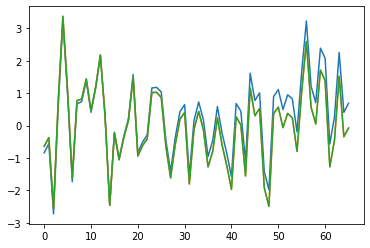

In [194]:
from scipy import signal
%matplotlib inline
from matplotlib import pyplot as plt 

plt.plot(X[:, 0])
plt.plot(signal.detrend(X[:, 0]))
plt.plot(signal.detrend(X, axis=0)[:,0])

In [197]:
signal.detrend(X, axis=0)[:,0][:5]

array([-0.63861856, -0.36882536, -2.55066254,  0.74970541,  3.37213746])

In [199]:
signal.detrend(X[:, 0])[:5]

array([-0.63861856, -0.36882536, -2.55066254,  0.74970541,  3.37213746])

In [85]:
t_20C['lon'].max()

<xarray.DataArray 'lon' ()>
array(358.75)